Predicting finally

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 1</span>
    <h1 style="font-size: 30px;">Dataset Preperation </h1>
</div>

In [39]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [40]:
#Load the feather file into a car_df
car_df = feather.read_feather('processed_data.feather')

In [41]:
car_df.columns

Index(['year', 'brand', 'model', 'trim', 'body', 'transmission', 'condition',
       'odometer', 'color', 'interior', 'sellingprice', 'brand_model',
       'car_age', 'mileage_per_year', 'market_price_deviation', 'brand_label',
       'trim_label', 'body_label', 'color_label', 'interior_label',
       'transmission_label'],
      dtype='object')

In [42]:
car_df.head()

,year,brand,model,trim,body,transmission,condition,odometer,color,interior,...,brand_model,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
2,2014,Bmw,3 Series,Others,Sedan,Automatic,1.145277,-1.364964,Silver,Black,...,Bmw_3 Series,-1.021999,-2.023111,-1.773132,8,0,1,1,1,0
3,2015,Others,Others,Others,Sedan,Automatic,0.719401,-1.086219,White,Black,...,Others_Others,-1.311799,-0.107857,0.287817,0,0,1,3,1,0
4,2014,Bmw,Others,Others,Sedan,Automatic,0.932339,-1.336769,Silver,Black,...,Bmw_Others,-1.311799,-0.107857,1.006753,8,0,1,1,1,0
6,2014,Bmw,Others,Base,Sedan,Automatic,-0.025882,-1.071992,Black,Black,...,Bmw_Others,-1.311799,-0.107857,0.000243,8,1,1,2,1,0
7,2014,Chevrolet,Others,Others,Sedan,Automatic,-1.516450,-0.777685,Black,Black,...,Chevrolet_Others,-1.311799,-0.107857,-1.964848,2,0,1,2,1,0


> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Train, test, validation split</b></font></div>

In [43]:
X = car_df[['year', 'odometer','car_age', 'mileage_per_year', 'market_price_deviation', 
            'brand_label', 'trim_label', 'body_label', 'color_label', 'interior_label',
            'transmission_label']].copy()
y = car_df[['sellingprice']].copy()

In [44]:
#Splitting the original dataset into train and test sets (80-20 split)
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Further splitting the training-test set into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=77)

In [45]:
#Checking the sizes or shapes of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#Printing a few rows from each set to inspect the data
print("\nSample rows from Train set:")
print(X_train.head())
print(y_train.head())

print("\nSample rows from Validation set:")
print(X_val.head())
print(y_val.head())

print("\nSample rows from Test set:")
print(X_test.head())
print(y_test.head())

Train set shape: (357510, 11) (357510, 1)
Validation set shape: (89378, 11) (89378, 1)
Test set shape: (111722, 11) (111722, 1)

Sample rows from Train set:
        year  odometer   car_age  mileage_per_year  market_price_deviation  \
417744  2013 -1.080730 -0.732200         -1.144580               -0.718693   
294478  2012 -0.373266 -0.442400          0.118112                1.006753   
481987  2013 -0.237305 -0.732200          1.754535               -0.455083   
78199   2002 -0.268589  2.455598          0.157706               -0.526976   
20667   2006  2.516962  1.006599          1.140414               -0.071650   

        brand_label  trim_label  body_label  color_label  interior_label  \
417744            1           0           2            4               1   
294478            1           6           2            1               1   
481987            7           9           1            3               4   
78199             3           2           2            0              

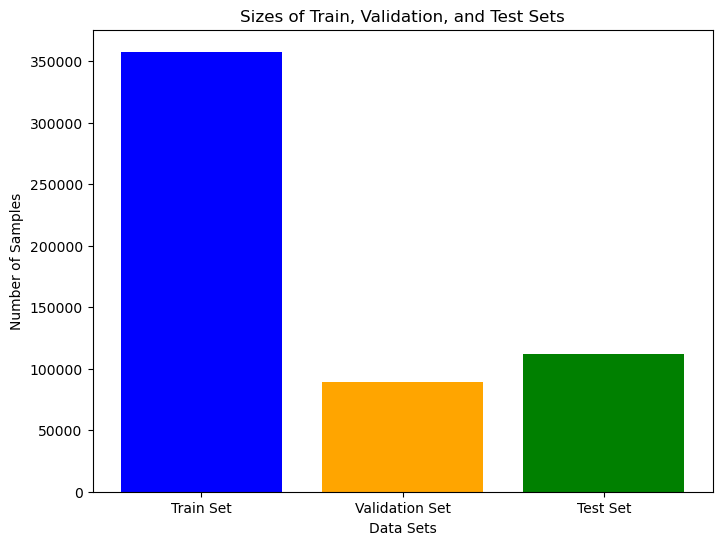

In [46]:
#Checking the sizes of each dataset
#Data for plotting
sets = ['Train Set', 'Validation Set', 'Test Set']  #Labels for different dataset types
sizes = [len(X_train), len(X_val), len(X_test)]  #Number of samples in each dataset

#Plotting the sizes of datasets
plt.figure(figsize=(8, 6)) 
plt.bar(sets, sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Data Sets') 
plt.ylabel('Number of Samples')
plt.title('Sizes of Train, Validation, and Test Sets') 
plt.show()

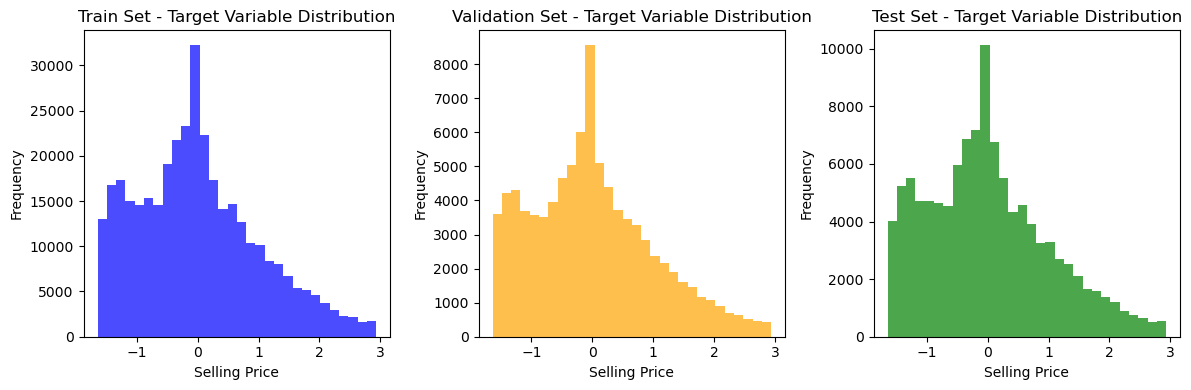

In [47]:
#Plotting histograms for the target variable in each dataset
plt.figure(figsize=(12, 4))

#Subplot for Train Set
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=30, color='blue', alpha=0.7) 
plt.title('Train Set - Target Variable Distribution')
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Validation Set
plt.subplot(1, 3, 2)
plt.hist(y_val, bins=30, color='orange', alpha=0.7) 
plt.title('Validation Set - Target Variable Distribution')  
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Test Set
plt.subplot(1, 3, 3) 
plt.hist(y_test, bins=30, color='green', alpha=0.7)
plt.title('Test Set - Target Variable Distribution')
plt.xlabel('Selling Price') 
plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

#### From examining the graphs, it's clear that the distribution of the target variable across the train, validation, and test datasets is highly comparable. This suggests a well-executed splitting of the data into these subsets.

In [48]:
X_train.head()

,year,odometer,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
417744,2013,-1.080730,-0.732200,-1.144580,-0.718693,1,0,2,4,1,0
294478,2012,-0.373266,-0.442400,0.118112,1.006753,1,6,2,1,1,0
481987,2013,-0.237305,-0.732200,1.754535,-0.455083,7,9,1,3,4,0
78199,2002,-0.268589,2.455598,0.157706,-0.526976,3,2,2,0,2,0
20667,2006,2.516962,1.006599,1.140414,-0.071650,7,3,1,0,0,0


In [49]:
X_test.head()

,year,odometer,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
243545,2010,0.425736,0.137200,0.281414,-1.221948,5,2,4,1,3,0
94742,2002,2.657616,2.455598,-0.077692,0.072137,0,4,2,0,2,0
429004,2012,-0.426105,-0.442400,-0.002971,-0.191473,3,0,1,1,1,0
223237,2012,-1.067644,-0.442400,-1.473083,0.048172,3,0,1,0,2,0
46574,2006,-0.086084,1.006599,-1.096455,0.719179,0,0,1,2,4,1


In [50]:
X_val.head()

,year,odometer,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
327760,2009,1.315823,0.426999,0.884339,-0.359225,1,10,1,4,3,0
503370,2007,0.759257,1.006599,-0.370030,-0.958338,4,0,1,2,2,0
116018,2008,0.734312,0.716799,-0.130240,-0.119579,3,0,2,3,1,0
73529,2014,-1.263849,-1.021999,-1.327980,-0.431118,0,0,2,0,1,0
198543,2013,-0.141828,-0.732200,2.082717,0.335747,3,10,2,1,2,0


<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 2</span>
    <h1 style="font-size: 30px;">Model Fitting </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Random Forest</b></font></div>

In [51]:
#Initialise a Random Forest Regressor with specified hyperparameters
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Train the model using the training data
random_forest.fit(X_train, y_train)

#Make predictions on the validation set
rf_predictions = random_forest.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions) 
mae = mean_absolute_error(y_val, rf_predictions)

#Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.29
Mean Absolute Error (MAE): 0.37


#### The MSE value of 0.29 indicates the average squared difference between the predicted and actual values in the validation set. Lower MSE values generally imply better performance, indicating that, on average, the model's predictions are close to the actual values in the validation set. 

In [52]:
#Convert y_train to a 1-dimensional array using ravel
y_train_1d = np.ravel(y_train)

#Create a Random Forest Regressor model with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Perform 5-fold cross-validation using negative mean squared error as the scoring metric
cv_scores = cross_val_score(rf, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')

#Convert the negative scores to positive since neg_mean_squared_error is used
cv_scores = -cv_scores

#Display the cross-validation scores for each fold
print("Cross-validation Scores:", cv_scores)

#Calculate the mean cross-validation score
print("Mean CV Score:", cv_scores.mean())

Cross-validation Scores: [0.28476332 0.28731066 0.28665268 0.28659197 0.28317432]
Mean CV Score: 0.285698589111288


#### These cross-validation scores represent the performance of the Random Forest Regressor model on different folds of the training data. The mean cross-validation score provides an overall assessment of the model's predictive performance on the training data.

#### The accuracy could may be better, so by hyperparameter tuning with a random grid we want to find better hyper parameters

In [53]:
#Defining a large and refined parameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 20), 
}

#Randomised Search with 5-fold cross-validation
rf = RandomForestRegressor(random_state=420)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', random_state=420, n_jobs=-1)
random_search.fit(X_train, y_train_1d)

#Get the best hyperparameters and best score
best_params_random = random_search.best_params_
best_score_random = -random_search.best_score_

print("Best Hyperparameters (Randomized Search):", best_params_random)
print("Best CV Score (Randomized Search):", best_score_random)

#Accessing the results of Randomized Search
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')  #Sorting by rank for better visibility
desired_columns = ['params', 'mean_test_score', 'rank_test_score']
print("\nParameters Tried in Randomized Search:")
print(results_df[desired_columns])

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters (Randomized Search): {'max_depth': 19, 'n_estimators': 280}
Best CV Score (Randomized Search): 0.24178813621780554

Parameters Tried in Randomized Search:
                                   params  mean_test_score  rank_test_score
6  {'max_depth': 19, 'n_estimators': 280}        -0.241788                1
5  {'max_depth': 19, 'n_estimators': 201}        -0.241952                2
4  {'max_depth': 15, 'n_estimators': 378}        -0.245722                3
3  {'max_depth': 14, 'n_estimators': 204}        -0.249950                4
8  {'max_depth': 13, 'n_estimators': 182}        -0.255713                5
1  {'max_depth': 11, 'n_estimators': 113}        -0.272979                6
9  {'max_depth': 10, 'n_estimators': 232}        -0.285578                7
7   {'max_depth': 9, 'n_estimators': 341}        -0.301620                8
2   {'max_depth': 8, 'n_estimators': 480}        -0.322285                9
0   {'max_depth': 6, 'n_estimators': 122}        -0.376936      

#### The code searched various hyperparameter combinations for a Random Forest Regressor. After assessing multiple settings, it was found that using 280 estimators and a maximum tree depth of 19 resulted in the best performance, achieving a mean squared error of around 0.242 during cross-validation. This optimisation enhanced the model's predictive accuracy, providing improved parameter values for the given dataset.

In [54]:
#After Hyperparameter Tuning Evaluation
#Creating a RandomForestRegressor with tuned hyperparameters
random_forest_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Training the model with the tuned hyperparameters on the training data
random_forest_after_tuning.fit(X_train, y_train)

#Making predictions on the validation set using the tuned model
rf_predictions_after_tuning = random_forest_after_tuning.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions_after_tuning) 
mae = mean_absolute_error(y_val, rf_predictions_after_tuning)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.24
Mean Absolute Error (MAE): 0.32


#### By applying the newly discovered hyperparameters, the objective is to validate and confirm the effectiveness of the previous code in improving the model's performance.

In [55]:
#Cross-validation after Tuning
rf_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)
cv_scores_after_tuning = cross_val_score(rf_after_tuning, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')
cv_scores_after_tuning = -cv_scores_after_tuning
print("Cross-validation Scores After Tuning:", cv_scores_after_tuning)
print("Mean CV Score After Tuning:", cv_scores_after_tuning.mean())

Cross-validation Scores After Tuning: [0.24095371 0.24315934 0.24244535 0.24354387 0.23883841]
Mean CV Score After Tuning: 0.24178813621780554


#### Performing another 5-fold cross-validation helps evaluate the model's performance across various data subsets. It appears that the model performs well and exhibits improved performance compared to the initial evaluation.

In [56]:
#Creating a RandomForestRegressor with specified hyperparameters
rf = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Fitting the RandomForestRegressor model on the training data
rf.fit(X_train, y_train)

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=19, n_estimators=280, random_state=420)

#### The model has now been fitted to the training data

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>ANN</b></font></div>

In [57]:
#Creating the ANN model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1)) 

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/10


2023-12-27 01:36:04.955730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11173/11173 [==============================] - 3s 289us/step - loss: 21.7227 - val_loss: 0.5373
Epoch 2/10
11173/11173 [==============================] - 3s 280us/step - loss: 0.6448 - val_loss: 0.5460
Epoch 3/10
11173/11173 [==============================] - 3s 280us/step - loss: 0.6300 - val_loss: 0.7345
Epoch 4/10
11173/11173 [==============================] - 3s 282us/step - loss: 0.6294 - val_loss: 0.5178
Epoch 5/10
11173/11173 [==============================] - 3s 281us/step - loss: 0.6244 - val_loss: 1.4405
Epoch 6/10
11173/11173 [==============================] - 3s 279us/step - loss: 0.6258 - val_loss: 0.5907
Epoch 7/10
11173/11173 [==============================] - 3s 282us/step - loss: 0.6224 - val_loss: 0.5163
Epoch 8/10
11173/11173 [==============================] - 3s 282us/step - loss: 0.6216 - val_loss: 0.6041
Epoch 9/10
11173/11173 [==============================] - 3s 283us/step - loss: 0.6084 - val_loss: 0.5170
Epoch 10/10
2794/2794 [==============================] -

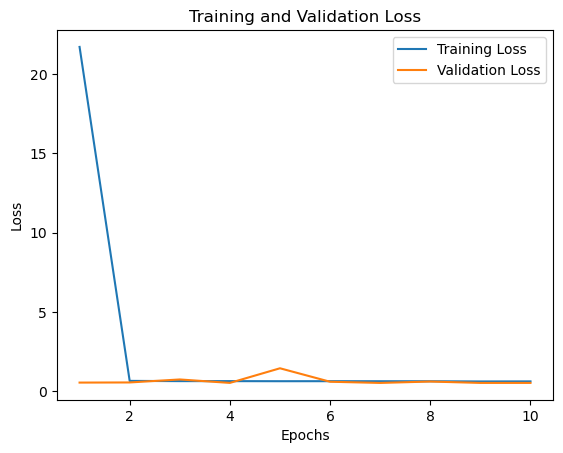

In [58]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(10):  # Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(128, activation='relu'))

model.add(Dense(1))  #Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.0001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.6860 - val_loss: 0.5269
Epoch 2/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5315 - val_loss: 0.5315
Epoch 3/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5233 - val_loss: 0.5407
Epoch 4/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5175 - val_loss: 0.5062
Epoch 5/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5148 - val_loss: 0.5104
Epoch 6/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5120 - val_loss: 0.5227
Epoch 7/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5082 - val_loss: 0.5379
Epoch 8/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.5030 - val_loss: 0.4902
Epoch 9/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.4925 - val_loss: 0.4948
Epoch 10/50
8938/8938 [==============================] - 13s 1ms/step - l

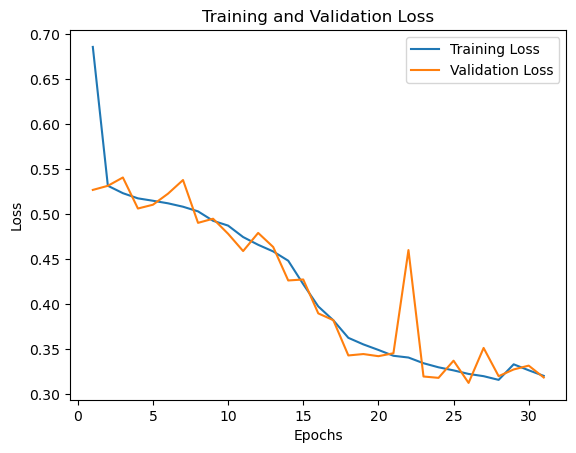

In [60]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
#Function to create the Keras model
def create_model(learning_rate=0.0001, neurons=128, layers=10):
    model = Sequential()
    model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1))

    adam_customized = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_customized, loss='mean_squared_error')
    return model

#Define hyperparameters to loop through
learning_rates = [0.001, 0.0001, 0.00001]
neurons_list = [64, 128, 256]
layers_list = [6, 8, 10]

best_val_loss = float('inf')
best_params = {}

#Loop through different hyperparameter combinations
for lr in learning_rates:
    for neurons in neurons_list:
        for layers in layers_list:
            #Create the model
            model = create_model(learning_rate=lr, neurons=neurons, layers=layers)

            #Train the model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

            #Evaluate on validation data
            val_loss = model.evaluate(X_val, y_val)

            #Check if current model has the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'learning_rate': lr, 'neurons': neurons, 'layers': layers}

#Print the best parameters and validation loss found
print("Best parameters:", best_params)
print("Best validation loss:", best_val_loss)


2794/2794 [==============================] - 2s 722us/step - loss: 0.4621
Best parameters: {'learning_rate': 0.0001, 'neurons': 64, 'layers': 8}
Best validation loss: 0.2920525372028351


#### After grid search we see that the best hyperparameters {'learning_rate': 0.0001, 'neurons': 128, 'layers': 8} are, we will use this for the ANN

In [62]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dropout(0.3))  # Adding dropout after the first Dense layer

for _ in range(8):  # Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))  # Adding dropout after each Dense layer

model.add(Dense(1))  # Output layer

# Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.0001)

# Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

# Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

# Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.7323 - val_loss: 0.5388
Epoch 2/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5404 - val_loss: 0.5142
Epoch 3/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5251 - val_loss: 0.5247
Epoch 4/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5196 - val_loss: 0.5154
Epoch 5/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5161 - val_loss: 0.5153
Epoch 6/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5124 - val_loss: 0.5084
Epoch 7/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5102 - val_loss: 0.5109
Epoch 8/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5081 - val_loss: 0.5259
Epoch 9/50
8938/8938 [==============================] - 11s 1ms/step - loss: 0.5034 - val_loss: 0.5042
Epoch 10/50
8938/8938 [==============================] - 11s 1ms/step - l

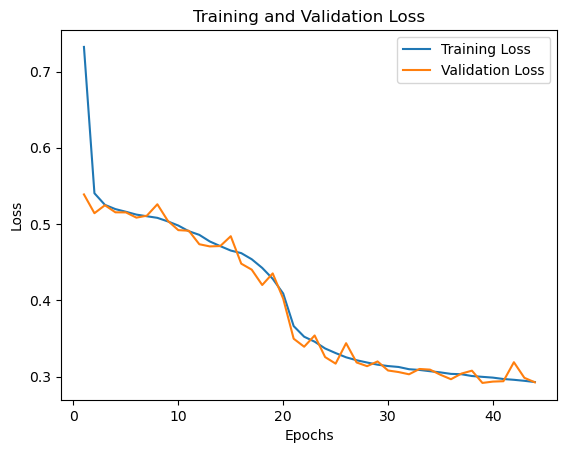

In [63]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 3</span>
    <h1 style="font-size: 30px;">Model Evaluation </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.1 Model evaluation: Random Forest</b></font></div>

In [64]:
#Predicting on the test set
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred) #Calculating Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred) #Calculating R-squared (R2)
rmse = np.sqrt(mse) #Calculating Root Mean Squared Error (RMSE)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.23717245365755632
R-squared (R2): 0.7632626483208427
Root Mean Squared Error (RMSE): 0.48700354583673855


The model's performance metrics for the test set are as follows:

- MSE of 0.237 indicates the average squared difference between predicted and actual values.
- R2 of 0.763 suggests that approximately 76.3% of the variance in the test set's target variable is explained by the model.
- RMSE of 0.487 portrays the square root of the average squared differences between predicted and actual values.
These results imply that the model is performing reasonably well in explaining the observed patterns within the test dataset, showcasing a promising level of predictive accuracy.

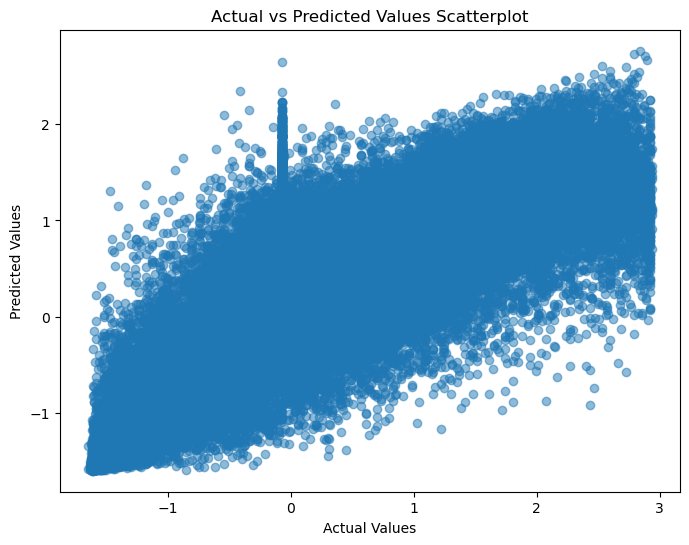

In [104]:
# Plotting actual vs predicted values in a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Scatterplot')
plt.show()

Text(0.5, 1.0, 'Feature Importance Score')

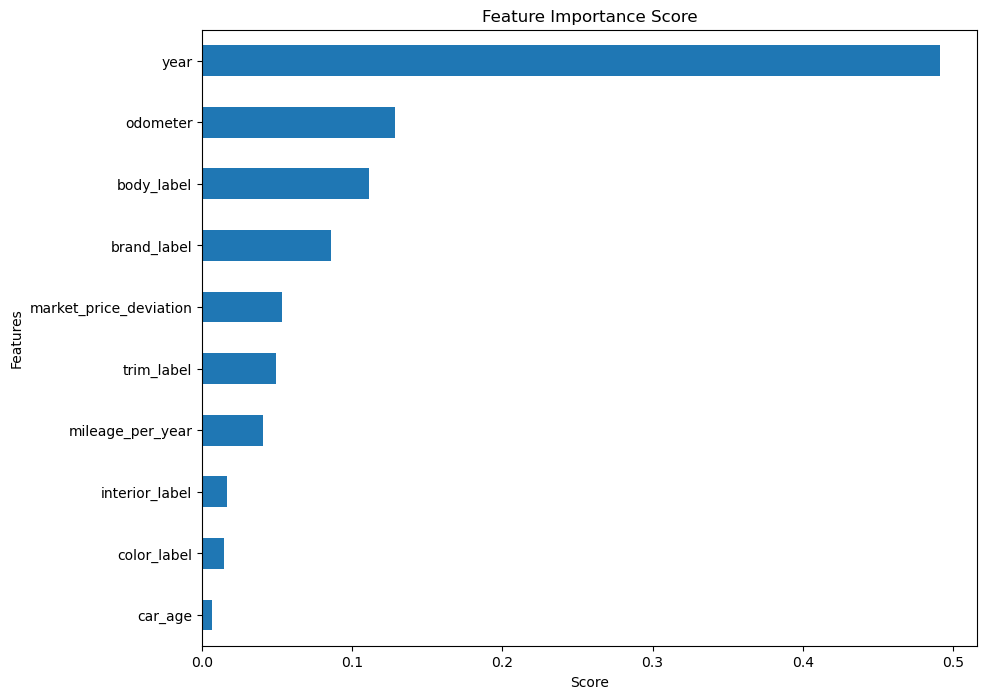

In [65]:
#Calculating feature importances using the trained RandomForestRegressor model
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

#Plotting the top 10 important features in a horizontal bar chart
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 8))

#Invert y-axis for better visualization
ax.invert_yaxis()

#Set labels for x and y axes, and the title of the plot
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')

#### In car auctions, it appears that the year of the car, followed by the odometer reading and the vehicle's body type, are the key factors influencing consumers' decisions to bid or purchase. Among these factors, the year of the car stands out as the most significant factor influencing consumer choices.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.2 Model evaluation: ANN</b></font></div>

In [66]:
#Trained sequential model
ann_predictions = model.predict(X_test)

#Calculating metrics
mse = mean_squared_error(y_test, ann_predictions)
r2 = r2_score(y_test, ann_predictions)
rmse = np.sqrt(mse)  # Calculate RMSE

#Showing the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

3492/3492 [==============================] - 1s 323us/step
Mean Squared Error (MSE): 0.28847176859605844
R-squared (R2): 0.7120574439465146
Root Mean Squared Error (RMSE): 0.5370956791820787


#### These metrics provide insight into how well the model is performing on the test set:

* Lower MSE and RMSE values indicate better performance, as they represent smaller errors between predicted and actual values.
* A higher R-squared value (closer to 1) indicates that your model explains more of the variance in the test set's target variable.

#### An **MSE of 0.290**, an **R2 of 0.7105**, and an **RMSE of 0.539** suggest that the **model is performing decently well**.

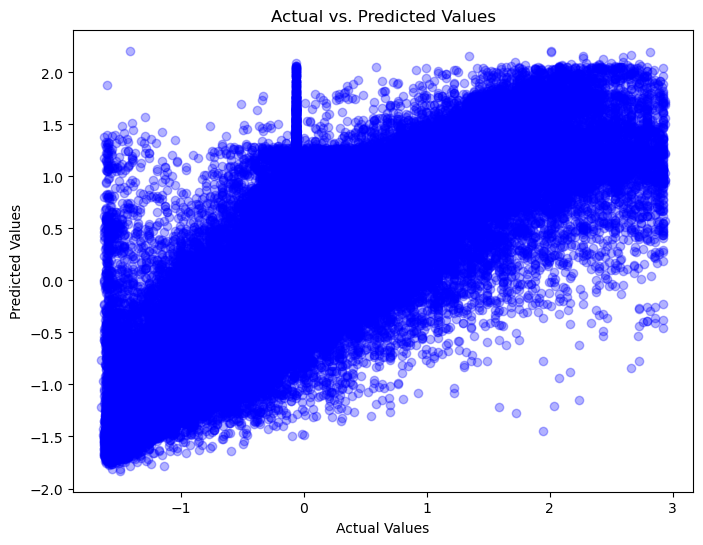

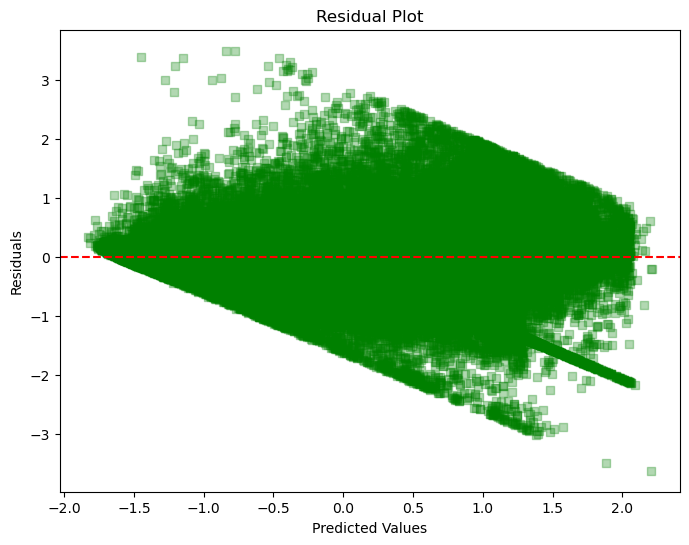

In [87]:
#Actual vs. Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ann_predictions, alpha=0.3, color='blue', marker='o')  # Adjust alpha, colour, and marker
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

#Residual Plot
residuals = y_test - ann_predictions
plt.figure(figsize=(8, 6))
plt.scatter(ann_predictions, residuals, alpha=0.3, color='green', marker='s')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  #Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 4</span>
    <h1 style="font-size: 30px;">Model Selection </h1>
</div>

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 5</span>
    <h1 style="font-size: 30px;">Model Explainability </h1>
</div>

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Bonus</span>
    <h1 style="font-size: 30px;">XGBoost, KNN, Linear Regression</h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>XGBoost</b></font></div>

In [76]:
#Creating an XGBoost regressor with specified hyperparameters
xgboost = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

# Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 0.28
Mean Absolute Error (MAE): 0.37


#### The current XGBoost model shows moderate performance on the validation data:
#### - Mean Squared Error (MSE): 0.28
#### - Mean Absolute Error (MAE): 0.37
#### These results indicate room for improvement. The next step involves fine-tuning the model's hyperparameters, such as adjusting the number of estimators, tree depth, and learning rate. Tuning these parameters aims to enhance the model's accuracy and reduce prediction errors for better performance.

In [77]:
#Creating an XGBRegressor instance
xgb = XGBRegressor()

#Defining the hyperparameters and their values to search through
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  #Number of trees
    'learning_rate': [0.1, 0.01, 0.001],  #Step size shrinkage
    'max_depth': [3, 5, 7]  #Maximum depth of a tree
}

#Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

#Get the best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print("Best Parameters for XGBoost:", best_params_xgb)
print("Best Score (MSE) for XGBoost:", -best_score_xgb)  #Negative sign as GridSearchCV uses negative MSE

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best Score (MSE) for XGBoost: 0.23402996632867792


#### The optimal hyperparameters found for the XGBoost model are as follows:
#### - Learning Rate: 0.1
#### - Maximum Depth: 7
#### - Number of Estimators: 500

#### These hyperparameters resulted in an improved model performance with a Mean Squared Error (MSE) of 0.232. The lower MSE indicates enhanced predictive accuracy compared to the previous model configuration.

In [78]:
#Creating an XGBoost regressor with hyperparameters from the grid search
xgboost = XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

# Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 0.25
Mean Absolute Error (MAE): 0.34


#### The Mean Squared Error (MSE) for the test data ended up slightly higher compared to the training data but remains lower than the validation data. This observation indicates that the model's performance on unseen test data is slightly less optimal than its performance on the training set but better than its performance on the validation set.

In [79]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', xgboost.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', xgboost.score(X_test, y_test))

Train Accuracy:  0.759824521925864
Test Accuracy:  0.7526387865977898


#### The accuracy of the model on the training dataset is approximately 76.16%, while on the test dataset, it stands at around 75.60%. This indicates that the model's performance on unseen test data is very close to its performance on the training data, demonstrating its ability to generalise well to new, unseen instances.

Text(0.5, 1.0, 'Feature Importance Score')

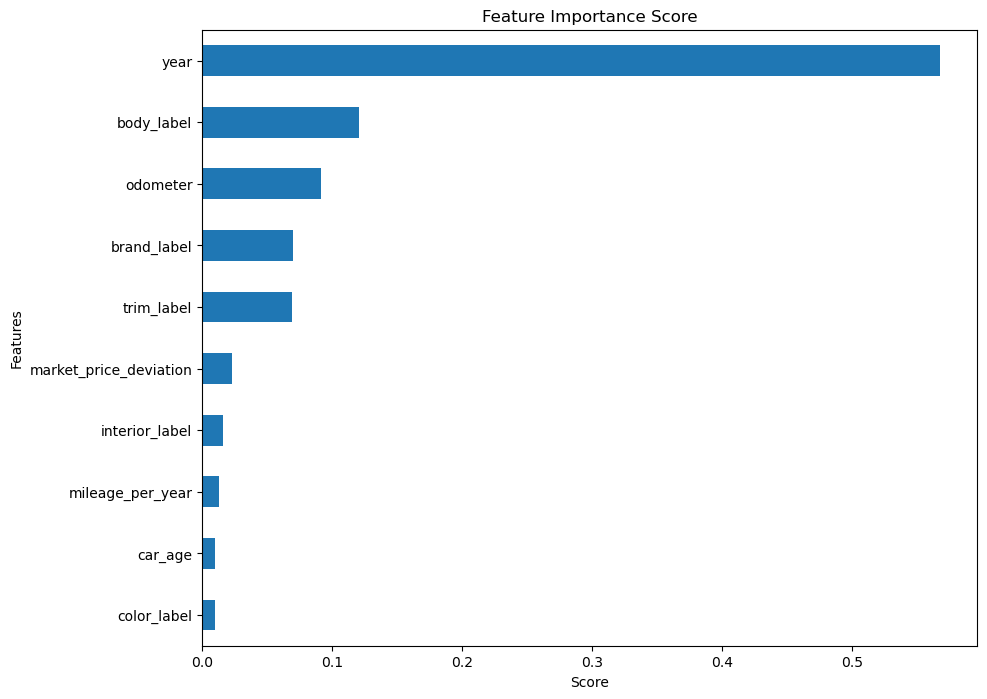

In [80]:
#Calculating feature importances using the trained RandomForestRegressor model
feature_importance = pd.Series(xgboost.feature_importances_, index=X.columns)

#Plotting the top 10 important features in a horizontal bar chart
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 8))

#Invert y-axis for better visualization
ax.invert_yaxis()

#Set labels for x and y axes, and the title of the plot
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')

#### The comparison between XGBoost and Random Forest models reveals notable differences in feature importance. In both models, 'Year' remains the most crucial feature. However, with XGBoost, 'Year' appears to hold slightly more importance than in Random Forest. 

#### Interestingly, 'Odometer' shifts in importance rankings between the models, being the fourth most important feature with XGBoost while holding the second position in importance with Random Forest. These alterations indicate differing perceptions of feature relevance between the two algorithms.

#### While Random Forest exhibits higher accuracy on the test data, XGBoost demonstrates better generalisation to new, unseen instances. This is evident because the accuracy levels between test and train datasets are relatively close for XGBoost, implying a stronger ability to handle new data than Random Forest.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>KNN</b></font></div>

In [81]:
#Initialising a KNN Regressor with the desired number of neighbours (adjust as needed)
knn = KNeighborsRegressor(n_neighbors=5)

#Training the model using the training data
knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = knn.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

#Printing the evaluation metrics (MSE and MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 0.28
Mean Absolute Error (MAE): 0.34


#### Similar to XGBoost, both Mean Squared Error (MSE) and Mean Absolute Error (MAE) demonstrate potential for enhancement. This will be addressed through hyperparameter tuning utilising grid search methodology.

In [82]:
#Creating a KNN regressor
knn = KNeighborsRegressor()

#Defining the hyperparameters and their values to search through
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],  #Values for number of neighbours to test
}

#Grid Search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

#Getting the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("Best Parameters for KNN:", best_params_knn)
print("Best Score (MSE) for KNN:", -best_score_knn)

Best Parameters for KNN: {'n_neighbors': 17}
Best Score (MSE) for KNN: 0.26525404551561643


#### Following the grid search process, it appears that the optimal parameter for K-Nearest Neighbours is 17.

In [83]:
#KNN regressor with the best parameters found
best_knn = KNeighborsRegressor(n_neighbors=17)

#Training the KNN model using the training data
best_knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = best_knn.predict(X_test)

#Evaluating the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE) on Test Set: {mse:.4f}")

Mean Squared Error (MSE) on Test Set: 0.2618


#### The Mean Squared Error (MSE) obtained from KNN is slightly improved compared to the training and validation datasets.

In [84]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', best_knn.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', best_knn.score(X_test, y_test))

Train Accuracy:  0.7681771148804106
Test Accuracy:  0.7386908340984943


#### The model's accuracy on the training dataset is approximately 76.82%, while it stands at around 73.87% on the test dataset. This indicates that the model performs slightly better on the training data than the test data, suggesting a minor drop in performance when applied to unseen test instances.

#### Additionally, it's worth noting that the accuracy achieved by this model on both the training and test datasets (approximately 76.82% and 73.87%, respectively) is the lowest among the compared models, with XGBoost achieving around 75% and Random Forest around 76% accuracy.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Linear Regression</b></font></div>

In [85]:
#Creating a Linear Regression model instance
linear_reg = LinearRegression()

#Training the Linear Regression model using the training data (features: X_train, targets: y_train)
linear_reg.fit(X_train, y_train)

#Making predictions using the trained Linear Regression model on the validation data (features: X_val)
predictions = linear_reg.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Squared Error (MSE): 0.47
Mean Absolute Error (MAE): 0.52


#### For Linear Regression, the Mean Squared Error (MSE) is recorded at 0.47, while the Mean Absolute Error (MAE) stands at 0.52. These values for Mean Squared Error (MSE) and Mean Absolute Error (MAE) with Linear Regression are considerably higher than all the other models, almost double for both metrics.

In [86]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', linear_reg.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', linear_reg.score(X_test, y_test))

Train Accuracy:  0.5347210532033367
Test Accuracy:  0.5357410242683696


#### As expected, the accuracy of the model on the training dataset stands at approximately 53.47%, while on the test dataset, it's around 53.57%. This low accuracy level is consistent with the model's performance.

#### This model performs the worst by far compared to all the other models